In [43]:
# https://deeplearningcourses.com/c/data-science-natural-language-processing-in-python
# https://www.udemy.com/data-science-natural-language-processing-in-python

# Author: https://lazyprogrammer.me

import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [44]:
# create substitution cipher

# one will act as the key, other as the value
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

# shuffle key and value
random.shuffle(letters2)

# populate map
for k, v in zip(letters1, letters2):
  true_mapping[k] = v

print(true_mapping)

{'a': 'q', 'b': 'r', 'c': 'h', 'd': 'p', 'e': 's', 'f': 'i', 'g': 'x', 'h': 'o', 'i': 'e', 'j': 'w', 'k': 'b', 'l': 'j', 'm': 'n', 'n': 'm', 'o': 'g', 'p': 'k', 'q': 'u', 'r': 'f', 's': 't', 't': 'y', 'u': 'a', 'v': 'c', 'w': 'l', 'x': 'v', 'y': 'z', 'z': 'd'}


In [45]:
from math import log
# the language model

# initialize Markov matrix - we are using add one smoothing
M = np.ones((26, 26))


# initial state distribution
# Initialize pi with ones for add-one smoothing
pi = np.ones(26)


# a function to update the Markov matrix
def update_transition(ch1, ch2):
  # ord('a') = 97, orb('b') = 98, ... orb converts character into integers
  i = ord(ch1) - 97 # by doing this a wil get mapped to 0 and so on till z will get mapped to 25
  j = ord(ch2) - 97
  M[i, j] += 1

# a function to update the initial state distribution
def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1


# get the log-probability of a word / token
def get_word_prob(word):
  # print ("word": word)
  i = ord(word[0]) - 97
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i, j])
    i = j # update i

  return logp


# get the probability of a sequence of words
def get_sequence_prob(words):
  # if input is a string, split into an array of tokens
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)

  return logp

In [46]:
# create a markov model based on an English dataset
# is an edit of https://www.gutenberg.org/ebooks/2710
# (I reoved the front and back matter)

# download the file
if not os.path.exists("moby_dick.txt"):
  print("Downloading moby dick...")
  r = requests.get("https://lazyprogrammer.me/course_files/moby_dick.txt")
  with open("moby_dick.txt", "w") as f:
    f.write(r.content.decode())
    print("Done!")

In [47]:
# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

# read the file
for line in open("moby_dick.txt"):
  line = line.rstrip()

  # there are blank lines in the file
  if line:
    line = regex.sub(' ', line) # replace all non-alpha characters with space

    # split the line into an array of words
    tokens = line.lower().split()

    # update the model
    for token in tokens:
      # update the first letter distribution
      first_letter = token[0]
      update_pi(first_letter)

      # update the Markov matrix
      for ch in token[1:]:
        update_transition(first_letter, ch)
        first_letter = ch

# normalize the probability only once after processing all lines
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [48]:
# encode a message
# this is a random excerpt from project Gutenberg's
# The adventure of Sherlock Holmes, by Authur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''




In [49]:
#  a function to encode an message
def encode_message(msg):
  # downcase
  msg = msg.lower()

  # replace non-alpha characters
  msg = regex.sub(' ', msg)

  # make the encoded message
  coded_msg = []
  for ch in msg:
    coded_ch = ch
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)

  return ''.join(coded_msg)


encoded_message = encode_message(original_message)
print("original:", original_message)
print("encoded:", encoded_message)


# decode a message
def decode_message(msg, word_map):
    decoded_msg = []
    for ch in msg:
      decoded_ch = ch
      if ch in word_map:
        decoded_ch = word_map[ch]
      decoded_msg.append(decoded_ch)

    return ''.join(decoded_msg)

original: I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.

encoded: e yosm jgamxsp pglm yos tyfssy qmp igamp  qt e svkshysp  yoqy yosfs lqt q nslt em q jqms loeho famt pglm rz gms lqjj gi yos xqfpsm  e jsmy yos gtyjsft q oqmp em farremx pglm yosef ogftst  qmp fshsecsp em svhoqmxs ylgksmhs  q xjqtt gi oqji qmp oqji  ylg iejjt gi toqx ygrqhhg  qmp qt naho emigfnqyegm qt e hgajp pstefs qrgay nett qpjsf  yg tqz mgyoemx gi oqji q pgdsm gyosf ksgkjs em yos msexorgafoggp em logn e lqt mgy em yos jsqty emysfstysp  ray logts regxfqkoest e lqt hgnksjjsp yg

In [50]:
# run an evolutionary algorithm to decode the message

# this is our initialization point
dna_pool = []
for _ in range(20):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

In [51]:
def evolve_offspring(dna_pool, n_children):
  # make a new children per offsprint
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      # switch
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)

  return offspring + dna_pool

In [52]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i > 0:
    # get offspring from the current dna pool
    dna_pool = evolve_offspring(dna_pool, 3)

  # compute the score for each dna
  dna2score = {}
  for dna in dna_pool:
    # populate map
    current_map = {}
    for k, v in zip(letters1, dna):
      current_map[k] = v

    # decode the message
    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # needs to be a string to be a dict key
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]


  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)



iter: 0 score: -2209.166530674065 best so far: -1980.7754335086
iter: 200 score: -1042.102167647854 best so far: -947.8052146935815
iter: 400 score: -1014.3408490236959 best so far: -929.5929889514528
iter: 600 score: -1001.3391657962887 best so far: -929.5929889514528
iter: 800 score: -1062.6128595311318 best so far: -929.5929889514528


In [53]:
# use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of original message:", get_sequence_prob(regex.sub(" ", original_message.lower())))

# which letter are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.5929889514528
LL of original message: -933.0339420615785
true: j, pred: z
true: k, pred: q
true: q, pred: j
true: z, pred: k


In [54]:
# print the final decoded message
print("Decoede message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoede message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

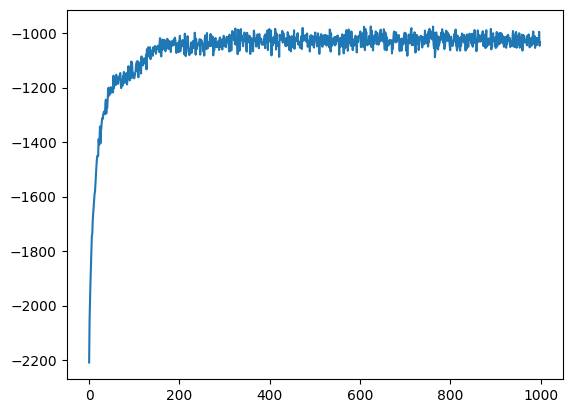

In [57]:
plt.plot(scores)
plt.show()

In [55]:
def convert_dna_string_to_rna_string(dna_string):
    output = {}
    inputArray = list(dna_string.lower())

    alphabets = list(string.ascii_lowercase)
    for i in range(len(inputArray)):
      output[alphabets[i]] = inputArray[i]
    return output


In [56]:
convert_dna_string_to_rna_string("You")

{'a': 'y', 'b': 'o', 'c': 'u'}